# Image Classification with Hugging Face Transformers and `Keras` 
### Image Classification Example using vanilla `Keras`, `Transformers`, `Datasets` and Vision Transformer

# Introduction

Welcome to this end-to-end Image Classification example using Keras and Hugging Face Transformers. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with `Tensorflow` & `Keras` to fine-tune a pre-trained vision transformer for image classification.

We are going to use the [EuroSAT](https://paperswithcode.com/dataset/eurosat) dataset for land use and land cover classification. The dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images.

More information for the dataset can be found at the [repository](https://github.com/phelber/eurosat).


We are going to use all of the great Feature from the Hugging Face ecosystem like model versioning and experiment tracking as well as all the great features of Keras like Early Stopping and Tensorboard.

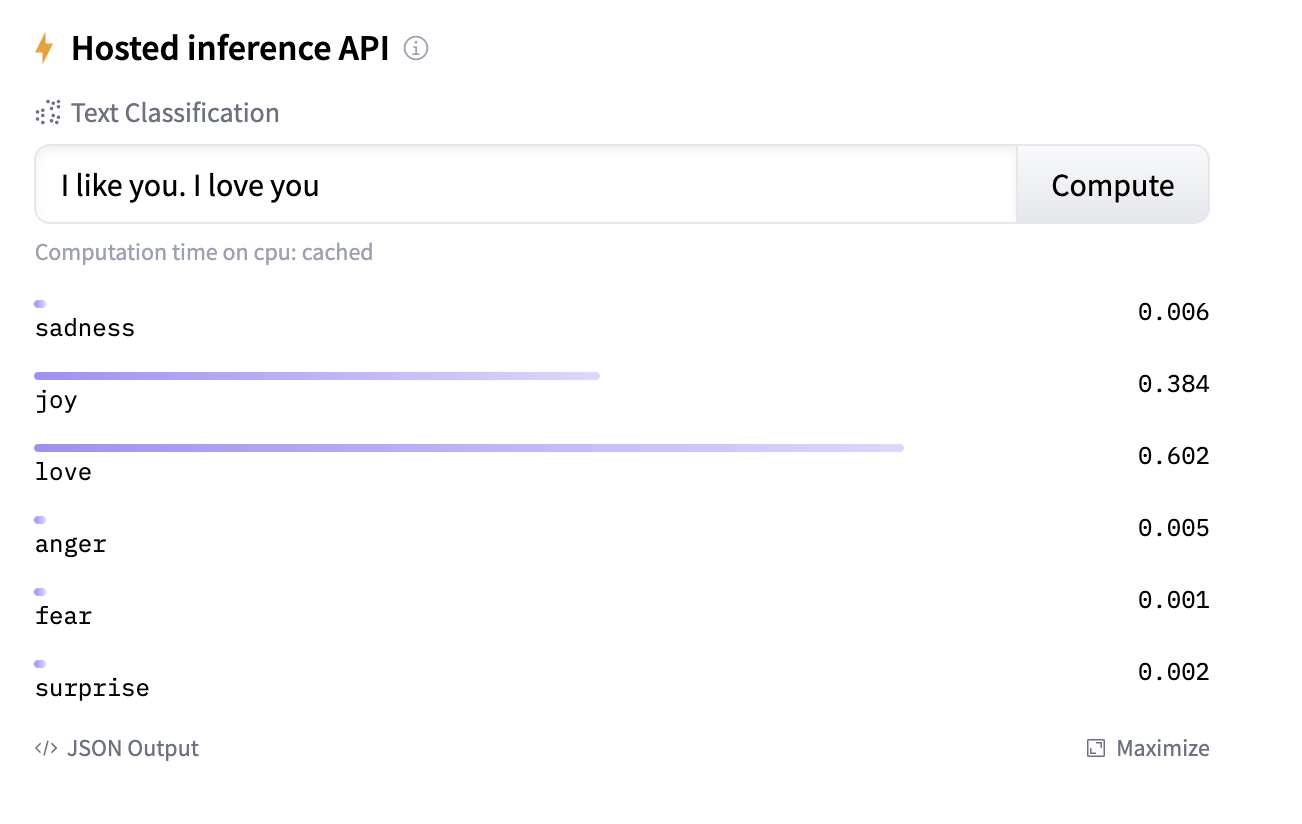

### Quick intro: Vision Transformer (ViT) by Google Brain
The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

![vision-transformer-architecture](./imgs/vision-transformer-architecture.png)

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

## Installation

In [5]:
#!pip install "tensorflow==2.6.0"
!pip install transformers "datasets>=1.17.0" tensorboard --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.4 MB 24.6 MB/s            
     |████████████████████████████████| 306 kB 64.8 MB/s            
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.3
    Uninstalling transformers-4.12.3:
      Successfully uninstalled transformers-4.12.3
  Attempting uninstall: datasets
    Found existing installation: datasets 1.16.1
    Uninstalling datasets-1.16.1:
      Successfully uninstalled datasets-1.16.1


In [ ]:
!sudo apt-get install git-lfs

This example will use the [Hugging Face Hub](https://huggingface.co/models) as remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


## Setup & Configuration

In this step we will define global configurations and paramters, which are used across the whole end-to-end fine-tuning proccess, e.g. `feature extractor` and `model` we will use. 

In this example are we going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In [1]:
model_id = "google/vit-base-patch16-224-in21k"

You can easily adjust the `model_id` to another Vision Transformer model, e.g. `google/vit-base-patch32-384`

## Dataset & Pre-processing

As Dataset we will use the [EuroSAT](https://paperswithcode.com/dataset/eurosat) a image classification dataset based on satellite images caputred by the Sentinel-2. The dataset consisting out of 10 classes (`Forest`, `River`, `Highway`, `AnnualCrop`,`SeaLake`, `HerbaceousVegetation`, `Industrial`, `Residential`, `PermanentCrop`, `Pasture`) with in total 27,000 labeled and geo-referenced images.


![eurosat-sample](./imgs/eurosat_overview_small.jpeg)  
Source: [EuroSAT](https://github.com/phelber/eurosat)

The `EuroSAT` is not yet availabe as dataset in the `datasets` library. To be able to create a `Dataset` instance we need to write a small little helper function, which will load our `Dataset` from the filesystem and create the instance to use later for training. 

As a first step we need to download dataset to our filesystem and unzip it.

In [2]:
!wget https://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip -d EuroSAT

--2022-01-03 13:24:52--  https://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  14.4MB/s    in 7.2s    

2022-01-03 13:24:59 (12.5 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

Archive:  EuroSAT.zip
   creating: EuroSAT/2750/
   creating: EuroSAT/2750/River/
  inflating: EuroSAT/2750/River/River_479.jpg  
  inflating: EuroSAT/2750/River/River_2178.jpg  
  inflating: EuroSAT/2750/River/River_65.jpg  
  inflating: EuroSAT/2750/River/River_1643.jpg  
  inflating: EuroSAT/2750/River/River_191.jpg  
  inflating: EuroSAT/2750/River/River_636.jpg  
  inflating: EuroSAT/2750/River/River_2490.jpg  
  inflating: EuroSAT/2750/River/River_2337.jpg  
  inflating: EuroSAT/2750/River/River_982.jpg  
  infl

We should now have a directory structure that looks like this:

```bash
EuroSAT/2750/
├── AnnualCrop
    └── AnnualCrop_1.jpg
├── Forest
    └── Forest_1.jpg
├── HerbaceousVegetation
    └── HerbaceousVegetation_1.jpg
├── Highway
    └── Highway_1.jpg
├── Pasture
    └── Pasture_1.jpg
├── PermanentCrop
    └── PermanentCrop_1.jpg
├── Residential
    └── Residential_1.jpg
├── River
    └── River_1.jpg
└── SeaLake
    └── SeaLake_1.jpg
```

As the time of writing this examples `datasets` does not yet support loading image dataset from the filesystem. Therefore we create a `create_image_folder_dataset` helper function to load the dataset from the filesystem. This method creates our `_CLASS_NAMES` and our `datasets.Features`. After that it iterates through the filesystem and creates a `Dataset` instance.

In [2]:
import os
import datasets

def create_image_folder_dataset(root_path):
  """creates `Dataset` from image folder structure"""
  
  # get class names by folders names
  _CLASS_NAMES= os.listdir(root_path)
  # defines `datasets` features`
  features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
  # temp list holding datapoints for creation
  img_data_files=[]
  label_data_files=[]
  # load images into list for creation
  for img_class in os.listdir(root_path):
    for img in os.listdir(os.path.join(root_path,img_class)):
      path_=os.path.join(root_path,img_class,img)
      img_data_files.append(path_)
      label_data_files.append(img_class)
  # create dataset
  ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
  return ds


In [3]:
eurosat_ds = create_image_folder_dataset("EuroSAT/2750")

We can display all our classes by inspecting the features of our dataset. Those `labels` can be later used to create a user friendly output when predicting.

In [4]:
img_class_labels = eurosat_ds.features["label"].names
img_class_labels

['Pasture',
 'HerbaceousVegetation',
 'AnnualCrop',
 'PermanentCrop',
 'Highway',
 'Residential',
 'Industrial',
 'River',
 'Forest',
 'SeaLake']

### Pre-processing

To train our model we need to convert our "Images" to `pixel_values`. This is done by a [🤗 Transformers Feature Extractor](https://huggingface.co/docs/transformers/master/en/main_classes/feature_extractor#feature-extractor) which allows us to `augement` and convert the images into a 3D Array to be fed into our model.

In [5]:
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers


feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def augmentation(examples):
    # print(examples["img"])
    examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
    return examples


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

# we are also renaming our label col to labels to use `.to_tf_dataset` later
eurosat_ds = eurosat_ds.rename_column("label", "labels")



2022-01-03 14:29:00.627322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 14:29:00.635585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 14:29:00.636574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 14:29:00.638230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

process our dataset using `.map` method with `batched=True`.

In [6]:
processed_dataset = eurosat_ds.map(process, batched=True)
processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = eurosat_ds.map(augmentation, batched=True)




  0%|          | 0/27 [00:00<?, ?ba/s]

Since our dataset doesn't includes any split we need to `train_test_split` ourself to have an evaluation/test dataset for evaluating the result during and after training. 

In [ ]:
# test size will be 15% of train dataset
test_size=.15

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'labels', 'pixel_values'],
        num_rows: 22950
    })
    test: Dataset({
        features: ['img', 'labels', 'pixel_values'],
        num_rows: 4050
    })
})

## Fine-tuning the model using `Keras`

Now that our `dataset` is processed, we can download the pretrained model and fine-tune it. But before we can do this we need to convert our Hugging Face `datasets` Dataset into a `tf.data.Dataset`. For this we will us the `.to_tf_dataset` method and a `data collator` (Data collators are objects that will form a batch by using a list of dataset elements as input).




## Hyperparameter

In [ ]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-euroSat'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


2022-01-03 14:24:12.654595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Converting the dataset to a `tf.data.Dataset`

In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

### Download the pretrained transformer model and fine-tune it. 

In [ ]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

2022-01-03 14:24:34.605604: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a do

In [ ]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

# import tensorflow as tf
# from transformers import TFViTModel

# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# # inputs
# pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# # model layer
# vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(10, activation='softmax', name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

### Callbacks

As mentioned in the beginning we want to use the [Hugging Face Hub](https://huggingface.co/models) for model versioning and monitoring. Therefore we want to push our models weights, during training and after training to the Hub to version it.
Additionally we want to track the peformance during training therefore we will push the `Tensorboard` logs along with the weights to the Hub to use the "Training Metrics" Feature to monitor our training in real-time. 



In [ ]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback,EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="accuracy",patience=1))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))



Cloning https://huggingface.co/philschmid/vit-base-patch16-224-in21k-euroSat into local empty directory.


![tensorboard](./imgs/tensorboard.png)

## Training

Start training with calling `model.fit`

In [ ]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/5
 10/717 [..............................] - ETA: 1:29:48 - loss: 2.2574 - accuracy: 0.2594 - top-3-accuracy: 0.4437

KeyboardInterrupt: 

## Create Model Card with evaluation results

To complete our Hugging Face Hub repository we will create a model card with the used hyperparameters and the evaluation results.

In [ ]:
train_results

In [19]:
from transformers.modelcard import TrainingSummary


eval_results = {
    "precision":float(results["overall_precision"]),
    "recall":float(results["overall_recall"]),
    "f1":float(results["overall_f1"]),
    "accuracy":float(results["overall_accuracy"]),
}

training_summary = TrainingSummary(
    model_name = hub_model_id,
    language = "de",
    tags=[],
    finetuned_from=model_id,
    tasks="token-classification",
    dataset=dataset_id,
    dataset_tags=dataset_id,
    dataset_args="default",
    eval_results=eval_results,
    hyperparameters={
        "num_train_epochs": num_train_epochs,
        "train_batch_size": train_batch_size,
        "eval_batch_size": eval_batch_size,
        "learning_rate": learning_rate,
        "weight_decay_rate": weight_decay_rate,
        "num_warmup_steps": num_warmup_steps,
        "fp16": fp16
    }
)
model_card = training_summary.to_model_card()

model_card_path = os.path.join(output_dir, "README.md")

with open(model_card_path, "w") as f:
    f.write(model_card)

push model card to repository

In [116]:
from huggingface_hub import HfApi

api = HfApi()

user = api.whoami(hub_token)

api.upload_file(
    token=hub_token,
    repo_id=f"{user['name']}/{hub_model_id}",
    path_or_fileobj=model_card_path,
    path_in_repo="README.md",
)

'https://huggingface.co/philschmid/gbert-base-germaner/blob/main/README.md'

![model-card](./imgs/model-card.png)

# Run Managed Training using Amazon Sagemaker

If you want to run this examples on Amazon SageMaker to benefit from the Training Platform follow the cells below. I converted the Notebook into a python script [train.py](./scripts/train.py), which accepts same hyperparameter and can we run on SageMaker using the `HuggingFace` estimator

In [ ]:
#!pip install sagemaker

In [ ]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

In [ ]:
from sagemaker.huggingface import HuggingFace

# gets role for executing training job
role = sagemaker.get_execution_role()
hyperparameters = {
	'model_id': 'deepset/gbert-base',
	'dataset_id': 'germaner',
	'num_train_epochs': 5,
	'train_batch_size': 16,
	'eval_batch_size': 32,
	'learning_rate': 2e-5,
	'weight_decay_rate': 0.01,
	'num_warmup_steps': 0,
	'hub_token': HfFolder.get_token(),
	'hub_model_id': 'sagemaker-gbert-base-germaner',
	'fp16': True
}


# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='train.py',
	source_dir='./scripts',
	instance_type='ml.p3.2xlarge',
	instance_count=1,
	role=role,
	transformers_version='4.12.3',
	tensorflow_version='2.5.1',
	py_version='py36',
	hyperparameters = hyperparameters
)

# starting the train job
huggingface_estimator.fit()